#  Getting the data

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Loading file from path
def loading_file():
    file_dir = '/home/nbuser/library/1. Classifier/3. Exploratory Data Analysis'        
    file_list = glob.glob(file_dir + '/*.csv')
    csv_file = file_list[0]
    return csv_file

# Import file imto Pandas DataFrame
def importing_file(csv_file):
    df = pd.read_csv(csv_file, sep=",")
    return df

# Saving path
def saving_file(file, file_name, save_dir):
    file.to_csv(os.path.join(save_dir,file_name))


In [3]:
# Importing file + Loading  file
news_df = importing_file(loading_file())

# Top 5 records
news_df.head()

,file_name,title,news_text,category
0,214.txt,Mansfield 0-1 Leyton Orient,An second-half goal from Andy Scott condemned ...,sports
1,303.txt,Film production 'falls' 40% in UK,The number of British films produced in the UK...,entertainment
2,083.txt,Hague 'given up' his PM ambition,Former Conservative leader William Hague says ...,politics
3,190.txt,SA return to Mauritius,Top seeds South Africa return to the scene of ...,sports
4,103.txt,Minimum rate for foster parents,Foster carers are to be guaranteed a minimum a...,politics


In [4]:
news_df.category.value_counts()

business         56
politics         49
sports           48
tech             36
entertainment    33
Name: category, dtype: int64

In [5]:
news_df.iloc[292, 3]

IndexError: single positional indexer is out-of-bounds

#  Data Exploration & Visualisation

In [12]:
!pip install gensim

     |████████████████████████████████| 24.2MB 38kB/s  eta 0:00:01    |▍                               | 327kB 3.1MB/s eta 0:00:080:00:08     |█████████████████▋              | 13.3MB 5.3MB/s eta 0:00:03     |██████████████████▉             | 14.2MB 3.6MB/s eta 0:00:03     |███████████████████████████▊    | 21.0MB 5.8MB/s eta 0:00:01     |█████████████████████████████▍  | 22.2MB 5.8MB/s eta 0:00:01
     |████████████████████████████████| 71kB 20.1MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-1.8.4-cp35-none-any.whl size=73429 sha256=7498022bb949e70420f422f3519994dc11536aa34815fe968583522c411fe1f8
  Stored in directory: /home/nbuser/.cache/pip/wheels/5f/ea/fb/5b1a947b369724063b2617011f1540c44eb00e28c3d2ca8692
Successfully built smart-open
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
!pip install --upgrade pip

     |████████████████████████████████| 1.4MB 3.5MB/s eta 0:00:01
  Found existing installation: pip 19.2.2
    Uninstalling pip-19.2.2:
      Successfully uninstalled pip-19.2.2


In [7]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [8]:
clean_text(news_df.iloc[2,2])

'snow patrol big winner ireland music honour meteor award pick accolad best irish band album thursdai belfast born glasgow base band collect prize ceremoni dublin point theatr westlif won award best irish pop act vote public beat member brian mcfadden franz ferdinand pick best intern band album paddi casei collect best irish male singer songwrit casei beat brian mcfadden damien rice juliett turner name best irish femal intern categori morrissei beat eminem usher robbi william best male harvei pip kyli minogu joss stone anastacia natasha bedingfield femal crown fan ceremoni treat perform rapper snoop dogg brian mcfadden delta goodrem thrill featur roll stone star ronni wood snow patrol success came year chart breakthrough album final straw think lot band wee bit kick success singer gari lightbodi drummer jonni quinn said good hard past year snow patrol support european tour later year nomin best irish band album'

In [10]:
!pip install wordcloud

     |████████████████████████████████| 358kB 3.5MB/s eta 0:00:01


In [12]:
%matplotlib inline

from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords=None,
                min_font_size = 10).generate(text) 
             
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

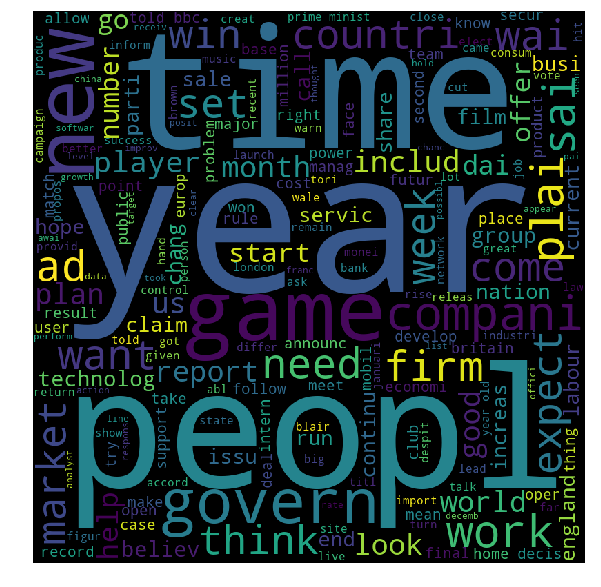

In [19]:
texts = ''
for index, item in news_df.iterrows():
    texts = texts + ' ' + clean_text(item['news_text'])
    
plot_word_cloud(texts)

In [14]:
def plot_word_cloud_for_category(df, category):
    text_df = news_df.loc[news_df['category'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + clean_text(item['news_text'])
    
    plot_word_cloud(texts)

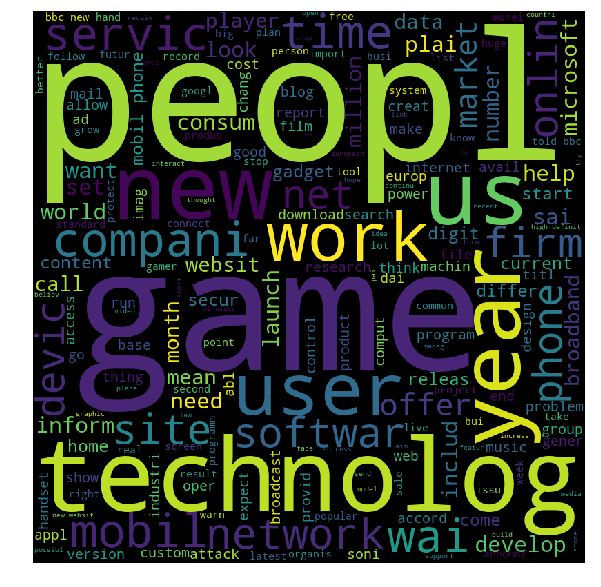

In [20]:
plot_word_cloud_for_category(news_df,'tech')

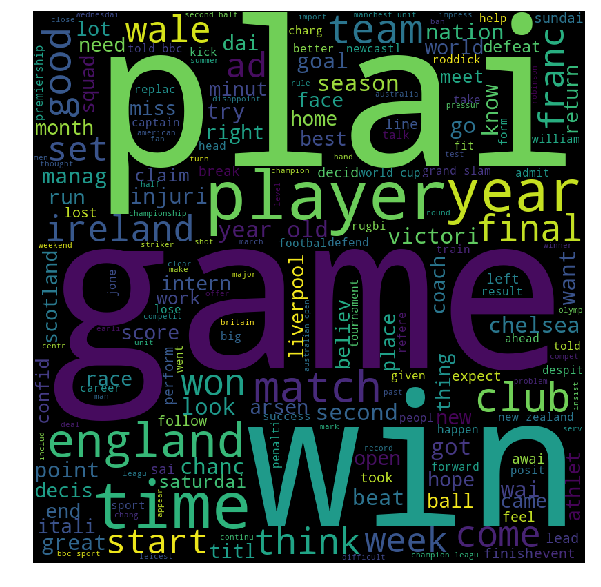

In [21]:
plot_word_cloud_for_category(news_df,'sports')

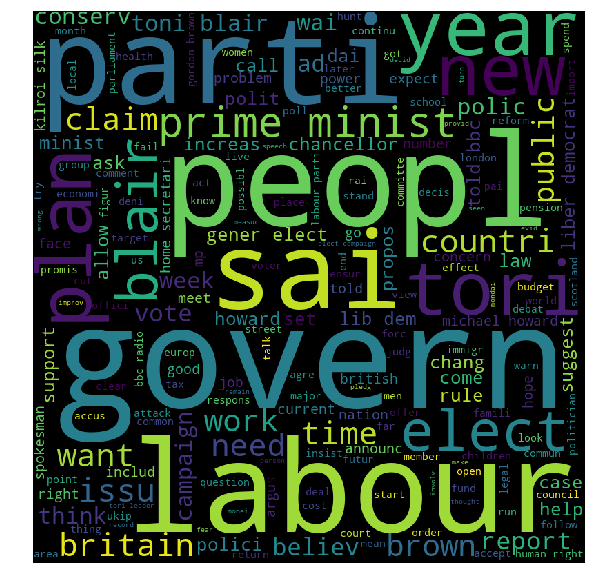

In [22]:
plot_word_cloud_for_category(news_df,'politics')

### 'SAID' is a STOP WORD here - we must remove it!

In [18]:
news_df['news_text'] = news_df['news_text'].str.replace('said', '')

In [59]:
df_x = news_df['news_text']
df_y = news_df['category']

# Building the Machine Learning model & pipeline

## Converting to Doc2Vec

In [60]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [61]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)
doc2vec_features

100%|██████████| 2003/2003 [00:00<00:00, 953705.40it/s]


matrix([[-0.00207085, -0.00270062,  0.00193005, ...,  0.00269746,
          0.00264674, -0.00132342],
        [ 0.06862415,  0.0295362 ,  0.07832153, ..., -0.12182761,
          0.00560538,  0.02962178],
        [ 0.08714214,  0.05121807,  0.09894347, ..., -0.14238063,
          0.0019772 ,  0.0361855 ],
        ...,
        [ 0.15699968,  0.06259325,  0.17688708, ..., -0.2638813 ,
          0.00501725,  0.06849514],
        [ 0.13152245,  0.03604633,  0.17621788, ..., -0.21803409,
          0.01067731,  0.10213754],
        [ 0.03182092,  0.02044943,  0.04169787, ..., -0.05288833,
          0.00054896,  0.01591462]], dtype=float32)

## Pipeline with Doc2Vec & LogisticRegression

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

pl_log_reg = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Logistic Regression: ', scores.mean())

100%|██████████| 1600/1600 [00:00<00:00, 546400.13it/s]
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 1602/1602 [00:00<00:00, 570832.98it/s]
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 1603/1603 [00:00<00:00, 1047106.26it/s]
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
100%|██████████| 1603/1603 [00:00<00:00, 675182.70it/s]
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarn

Accuracy for Logistic Regression:  0.30653184218877794


## Pipeline with Doc2Vec & RandomForest

In [63]:
from sklearn.ensemble import RandomForestClassifier

pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
100%|██████████| 1604/1604 [00:00<00:00, 1877138.29it/s]


Accuracy for RandomForest :  0.27510355941740766


## Pipeline with Doc2Vec & XGBoost

In [65]:
!pip install xgboost

     |████████████████████████████████| 142.8MB 7.3kB/s eta 0:00:01     |██████████▎                     | 46.0MB 28.9MB/s eta 0:00:04��██████                    | 53.1MB 2.5MB/s eta 0:00:36     |█████████████████▏              | 76.7MB 376kB/s eta 0:02:56     |██████████████████▊             | 83.6MB 13.3MB/s eta 0:00:05     |███████████████████▉            | 88.5MB 13.3MB/s eta 0:00:05     |█████████████████████▉          | 97.5MB 5.4MB/s eta 0:00:09     |██████████████████████          | 98.4MB 5.4MB/s eta 0:00:09     |███████████████████████▉        | 106.4MB 967kB/s eta 0:00:38     |█████████████████████████▎      | 112.6MB 9.3MB/s eta 0:00:04     |█████████████████████████████▉  | 133.2MB 920kB/s eta 0:00:11


In [66]:
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

100%|██████████| 1600/1600 [00:00<00:00, 586052.43it/s]
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
100%|██████████| 1602/1602 [00:00<00:00, 678166.63it/s]
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
100%|██████████| 1603/1603 [00:00<00:00, 667474.37it/s]
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that

Accuracy for XGBoost Classifier :  0.30861371591699


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Converting to Tf-Idf

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [68]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [69]:
tfidf_vectors.shape

(2003, 17723)

In [70]:
print(tfidf_vectors)

  (0, 17592)	0.06299268330625443
  (0, 17414)	0.04161667663552013
  (0, 17303)	0.21083392842672982
  (0, 17277)	0.07740030520398901
  (0, 17184)	0.086979036577143
  (0, 17116)	0.09708816799306094
  (0, 17043)	0.05516720343747269
  (0, 15907)	0.032541991756182075
  (0, 15717)	0.46143582566138963
  (0, 15105)	0.04727689181643753
  (0, 15071)	0.09049623897407917
  (0, 14481)	0.06676077374530709
  (0, 14288)	0.054036063608330444
  (0, 14281)	0.07686990516122504
  (0, 14200)	0.05920688775234539
  (0, 13550)	0.03344043706859032
  (0, 12827)	0.0650429795748767
  (0, 11734)	0.05481855590827215
  (0, 11123)	0.13352154749061418
  (0, 10935)	0.21049964999885892
  (0, 10766)	0.02416468471260523
  (0, 10479)	0.16829477762276862
  (0, 10383)	0.08106557378396884
  (0, 9679)	0.0372708307500791
  (0, 9576)	0.10182569004440499
  :	:
  (2002, 3092)	0.03519991065949139
  (2002, 2916)	0.01739099193578081
  (2002, 2759)	0.021156065895822647
  (2002, 2750)	0.014842482249431872
  (2002, 2501)	0.02844013105394

## Pipeline with Tf-Idf & LogisticRegression

In [71]:
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Tf-Idf & Logistic Regression:  0.8726832731367724


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

## Pipeline with Tf-Idf & RandomForest

In [72]:
pl_random_forest_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & RandomForest : ', scores.mean())

Accuracy for Tf-Idf & RandomForest :  0.8592281120336406


## Pipeline with Tf-Idf & XGBoost

In [73]:
pl_xgb_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb_tf_idf, df_x, df_y, cv=5)
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an 

Accuracy for Tf-Idf & XGBoost Classifier :  0.9221213819000761


/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())